<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
df = pd.read_csv('SupplyChainDataset.csv', encoding = 'latin-1')

# Old System

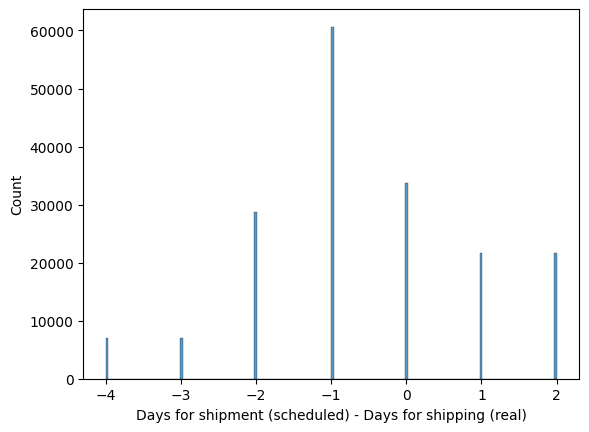

In [8]:
sns.histplot(df['Days for shipment (scheduled)'] - df['Days for shipping (real)'])
plt.xlabel('Days for shipment (scheduled) - Days for shipping (real)')
plt.ylabel('Count')
plt.show()

# Cleaning the Data

In [9]:
# Remove Na and Empty Columns

df.drop(['Delivery Status', 'Order Status', 'Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 
         'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 
         'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'Category Id', 'Department Id', 'Order Customer Id', 
         'Order Id', 'Order Item Cardprod Id', 'Order Item Id', 'Product Name', 'Days for shipment (scheduled)'], axis = 1, inplace = True) 
df.drop('Late_delivery_risk', axis = 1, inplace = True)
df.dropna(inplace = True) #remove 1 missing value

In [10]:
df['order date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date'] = pd.to_datetime(df['shipping date (DateOrders)'])

df['order date'] = df['order date'].apply(lambda x: x.timestamp())
df['shipping date'] = df['shipping date'].apply(lambda x: x.timestamp())

df.drop(['order date (DateOrders)', 'shipping date (DateOrders)'], axis = 1, inplace = True)

In [11]:
df.to_csv('SupplyChainDataset_prediction.csv', index = False)

# Encoding

### Label Encoding

In [12]:
X = df.drop(['Days for shipping (real)'], axis = 1)
y = df['Days for shipping (real)']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [15]:
# Select columns for one-hot encoding
one_hot_cols = [0, 3, 5, 7, 10]

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [16]:
le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

## Scale the Data

In [17]:
scaler = StandardScaler()

X_train.iloc[:, 73:] = scaler.fit_transform(X_train.iloc[:, 73:])
X_test.iloc[:, 73:] = scaler.transform(X_test.iloc[:, 73:])

/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_29197/2172369968.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.iloc[:, 73:] = scaler.fit_transform(X_train.iloc[:, 73:])
/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_29197/2172369968.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, 73:] = scaler.transform(X_test.iloc[:, 73:])


In [18]:
# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Prediction

## Choosing the Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))
print('r2_score', r2_score(y_test, y_pred))

rMSE 1.3353067501496976
r2_score 0.3263215219857082


In [20]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))
print('r2_score', r2_score(y_test, y_pred))

rMSE 1.479702279448588
r2_score 0.17274524907741295


In [21]:
from sklearn.linear_model import Ridge

ridge = Ridge()

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))
print('r2_score', r2_score(y_test, y_pred))

rMSE 0.5742991295186439
r2_score 0.8753859817395789


In [22]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(compute_score=True)

br.fit(X_train, y_train)

y_pred = br.predict(X_test)

with open('br.pkl', 'wb') as f:
  pickle.dump(br, f)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))
print('r2_score', r2_score(y_test, y_pred))

rMSE 0.11677731876902635
r2_score 0.9948476235869476


## try

In [23]:
y_pred = br.predict(X_test)

residuals = y_test - y_pred

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.11677731876902635


In [24]:
import numpy as np
import pandas as pd

# Initialize a dictionary to store the squared errors and average predictions for each class
mse_dict = {label: {'errors': [], 'preds': []} for label in np.unique(y_test)}

# Calculate the squared error and average prediction for each instance and add them to the corresponding class lists
for true_label, pred_label, error in zip(y_test, y_pred, (y_test - y_pred) ** 2):
    mse_dict[true_label]['errors'].append(error)
    mse_dict[true_label]['preds'].append(pred_label)

# Calculate the mean squared error and average prediction for each class and add the results to the table_data list
table_header = ['Class', 'Instances', 'RMSE', 'Average Predicted Value']
table_data = []
for label in mse_dict:
    instances = len(mse_dict[label]['errors'])
    if instances > 0:
        mse = np.mean(mse_dict[label]['errors'])
        rmse = np.sqrt(mse)
        avg_pred = np.mean(mse_dict[label]['preds'])
        table_data.append([label, instances, f'{rmse:.4f}', f'{avg_pred:.4f}'])
    else:
        table_data.append([label, 'no instances', 'N/A', 'N/A'])

# Print the table
print(pd.DataFrame(table_data, columns=table_header))

   Class  Instances    RMSE Average Predicted Value
0      0       1017  0.4939                  0.4939
1      1        953  0.5053                  0.4947
2      2      11453  0.0057                  1.9966
3      3       5655  0.0049                  2.9982
4      4       5609  0.0045                  3.9995
5      5       5699  0.0049                  5.0011
6      6       5718  0.0053                  6.0021


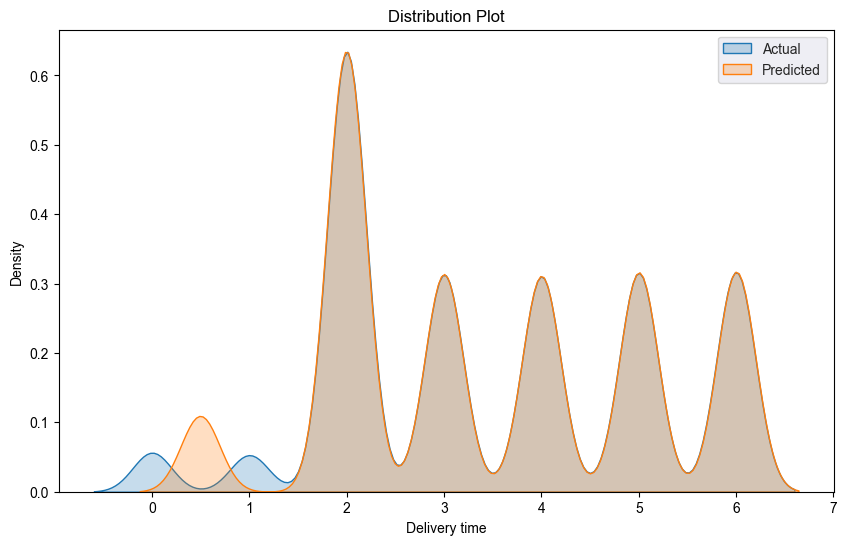

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette('colorblind')
sns.set_style('darkgrid')
sns.kdeplot(y_test.ravel(), label='Actual', fill=True)
sns.kdeplot(y_pred.ravel(), label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

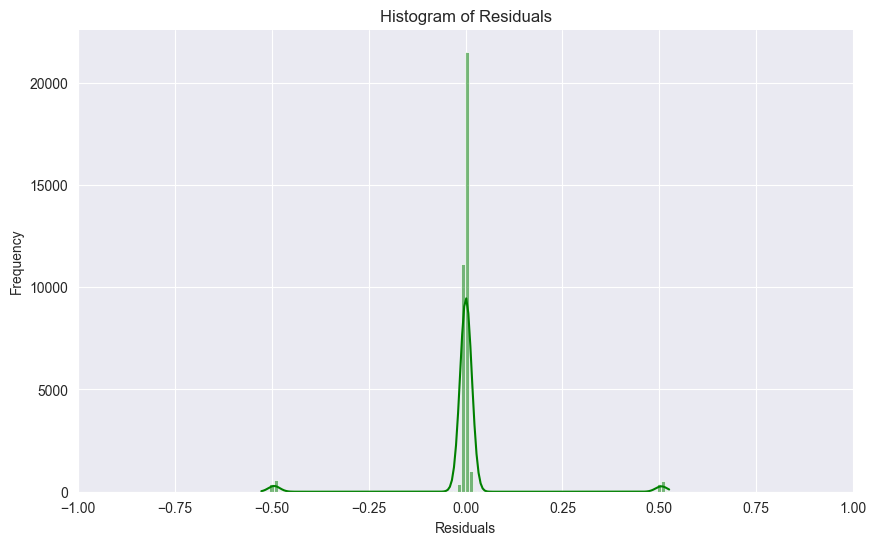

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('colorblind')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-1, 1))
sns.despine()
plt.show()

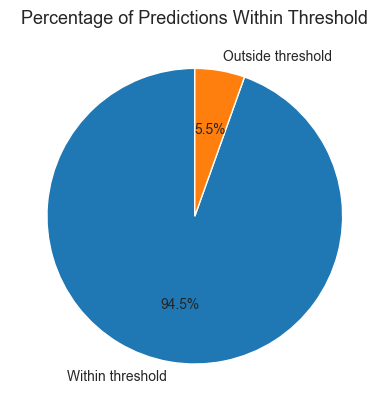

In [27]:
within_threshold = (np.abs(y_pred.ravel() - y_test.ravel()) < 0.1).mean() #0.1 = 2.4 hours
outside_threshold = 1 - within_threshold
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Predictions Within Threshold', fontsize=13)
plt.show()

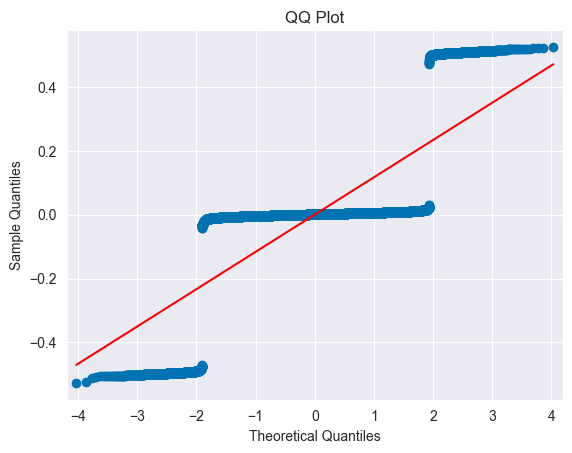

In [28]:
import statsmodels.api as sm

fig, ax = plt.subplots()
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()